**This Notebook will run on an AWS p2.8xlarge ubuntu deep learning machine with GPU**

### This book approaches the dataset a multiclass problem, specifially looking to classify type of skin anomaly
- In this book, focus will be put on balancing classes and tweaking the model
- Sizes of images have been reduced to .25 of original size, from (450, 600, 3) to (112, 150, 3)


In [3]:
#imports
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from progressbar import ProgressBar

In [4]:
#Loading the full DataFrame of dummy columns and categorical data (y)
main = pd.read_csv('./main.csv', index_col = 'Unnamed: 0')

In [5]:
main.head()

,image,NV,BKL,VASC,DF,MEL,BCC,AKIEC,Category,Malignant
0,ISIC_0024306,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,ISIC_0024307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,ISIC_0024308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,ISIC_0024309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,ISIC_0024310,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1


In [6]:
main.shape

(10015, 10)

In [7]:
#Creating a 4 dimensional array of zeros to later overwrite with image data.

images=np.zeros((10015, 112, 150, 3), dtype=np.int32)
#Number of total images, 
#pixel dimension height, pixel dimension width, 3 layers(RGB)

In [8]:
#Loading all 10015 images (X)

bar = ProgressBar()

for i in bar(range(0,10015)):
    n = 24306+i
    x = ndimage.imread(f'./data/ISIC2018_Task3_Training_Input/ISIC_00{n}.jpg')
    images[i,:,:,:] = imresize(x, .25)

100% |########################################################################|


In [9]:
#This is to scale, turning each shade of red, green, blue (layer) into a value between 0 and 1
bar = ProgressBar()
images = [image/255 for image in bar(images)]

100% |########################################################################|


_________

In [10]:
images = np.asarray(images, dtype=np.float32)

In [11]:
len(images)

10015

#### Balancing Classes

In [12]:
#mainframe

In [13]:
main.Category.value_counts()

0    6705
4    1113
1    1099
5     514
6     327
2     142
3     115
Name: Category, dtype: int64

In [14]:
frames = [main[main.Category == i].sample(n = 1000, replace=True) for i in main.Category.value_counts().index]

master = pd.concat(frames, axis = 0)

master.shape

(7000, 10)

In [15]:
master.Category.value_counts()

3    1000
6    1000
2    1000
5    1000
1    1000
4    1000
0    1000
Name: Category, dtype: int64

In [16]:
master.index

Int64Index([7534, 6657, 5841,  470, 7041, 9735,  138, 9489,  707, 2374,
            ...
            9116,   12, 5667,  247, 4429, 4746, 4871, 5661, 9484, 9248],
           dtype='int64', length=7000)

In [17]:
samp_images = []
for n in master.index:
    samp_images.append(images[n])
    

master['picture'] = samp_images

master.head()

,image,NV,BKL,VASC,DF,MEL,BCC,AKIEC,Category,Malignant,picture
7534,ISIC_0031840,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.901961, 0.54902, 0.639216], [0.913725, 0...."
6657,ISIC_0030963,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.776471, 0.517647, 0.490196], [0.772549, 0..."
5841,ISIC_0030147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.862745, 0.494118, 0.470588], [0.854902, 0..."
470,ISIC_0024776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.854902, 0.576471, 0.592157], [0.85098, 0...."
7041,ISIC_0031347,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,"[[[0.92549, 0.682353, 0.717647], [0.929412, 0...."


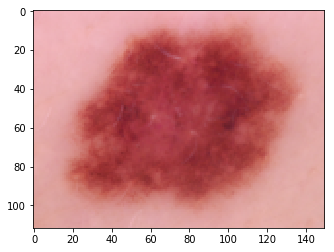

In [19]:
#test to make sure that indexes are correct
plt.imshow(master.picture[7041])

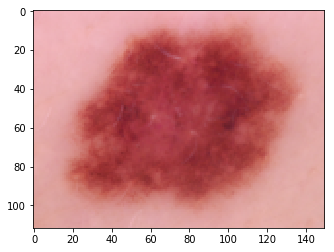

In [21]:
plt.imshow(images[7041])

--------------

In [22]:
#train_test_split

X = np.asarray(samp_images)
y = master.Category

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Need to change the categories to categorical for keras to make sense of them.

y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

#### Model

In [23]:
#Binary

model = Sequential()


#Convolution 1
model.add(Conv2D(50,3,3,input_shape=(112,150,3)))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(3,3)))

#Convolution 2
model.add(Conv2D(100,2,2))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 3
model.add(Conv2D(200,2,2))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))

#Convolution 4
model.add(Conv2D(400,3,3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3,3)))

#Flatten
model.add(Flatten())

#Last layer          
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

#Much of this layout was adapted from 2 outside sources, listed in the footnotes as [1][2]

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
#note- ran one last epoch to return more accurate predictions

history = model.fit(X_train, y_train, epochs=76, verbose=1,
                    batch_size = 50,
                    validation_data=(X_test, y_test))

Train on 5250 samples, validate on 1750 samples
Epoch 1/1
5250/5250 [==============================] - 55s 10ms/step - loss: 0.0758 - acc: 0.9709 - val_loss: 0.6118 - val_acc: 0.8606


In [27]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [29]:
final_multi_model_history = pd.DataFrame(history.history)

In [34]:
final_multi_model_history.head()

,val_loss,val_acc,loss,acc
0,1.479252,0.416571,1.693772,0.302476
1,1.444298,0.429143,1.484760,0.379429
2,1.406301,0.445143,1.400494,0.421333
3,1.368500,0.467429,1.304501,0.459429
4,1.293428,0.486286,1.205311,0.520571


In [45]:
final_multi_model_history.tail()

,val_loss,val_acc,loss,acc
71,0.726201,0.801143,0.077493,0.973524
72,0.537547,0.864571,0.120486,0.956952
73,0.593711,0.854857,0.115222,0.959429
74,0.682189,0.832000,0.100739,0.964762
75,0.611844,0.860571,0.075845,0.970857


In [37]:
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

In [38]:
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.611844191074
acc: 0.860571428708


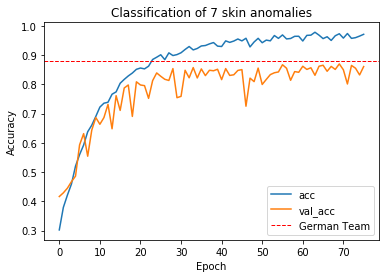

In [47]:
plt.plot(final_multi_model_history['acc'], label = 'acc')
plt.plot(final_multi_model_history['val_acc'], label = 'val_acc')
plt.axhline(y=0.881, linewidth=1, color='r', linestyle = '--', label = 'German Team')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification of 7 skin anomalies');

--------------------